In [1]:
%matplotlib widget
import os
import gc
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.transforms import PILToTensor
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from diffusers.models.unet_2d_condition import UNet2DConditionModel
from diffusers import DDIMScheduler
from diffusers import StableDiffusionPipeline

In [2]:
class MyUNet2DConditonModel(UNet2DConditionModel):
    
    def forward(self,
                sample,
                timestep,
                up_ft_indices, # up 최대 인덱스
                encoder_hidden_states,
                class_labels=None,
                timestep_cond=None,
                attention_mask=None,
                cross_attention_kwargs=None):

        # 셋팅 부분은 기존과 거의 같음
        default_overall_up_factor = 2**self.num_upsamplers
        forward_upsample_size = False
        upsample_size = None

        if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
            # logger.info("Forward upsample size to force interpolation output size.")
            forward_upsample_size = True

        # prepare attention_mask
        if attention_mask is not None:
            attention_mask = (1 - attention_mask.to(sample.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0


        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)

        # timesteps does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=self.dtype)

        emb = self.time_embedding(t_emb, timestep_cond)

        if self.class_embedding is not None:
            if class_labels is None:
                raise ValueError("class_labels should be provided when num_class_embeds > 0")

            if self.config.class_embed_type == "timestep":
                class_labels = self.time_proj(class_labels)

            class_emb = self.class_embedding(class_labels).to(dtype=self.dtype)
            emb = emb + class_emb

        # 추가 임베딩은 없어서 안하는 듯

        # 2. pre-process
        sample = self.conv_in(sample)

        # cotnrolnet 등은 고려하지 않아서 그냥 unet forward 코드만
        # 3. down
        down_block_res_samples = (sample,)
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

            down_block_res_samples += res_samples


        # 4. mid
        if self.mid_block is not None:
            sample = self.mid_block(
                sample,
                emb,
                encoder_hidden_states=encoder_hidden_states,
                attention_mask=attention_mask,
                cross_attention_kwargs=cross_attention_kwargs,
            )


        # 5. up
        # 논문에선 up block에서 부터 feature를 뽑는다고 했으므로
        up_ft = {}
        for i, upsample_block in enumerate(self.up_blocks):
            # DIFT를 뽑고 나면 break
            if i > np.max(up_ft_indices):
                break

            is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            if not is_final_block and forward_upsample_size:
                upsample_size = down_block_res_samples[-1].shape[2:]
                
            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    upsample_size=upsample_size,
                    attention_mask=attention_mask,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample, temb=emb, res_hidden_states_tuple=res_samples, upsample_size=upsample_size
                )

            # feature를 저장
            if i in up_ft_indices:
                up_ft[i] = sample.detach()

        output = {}
        output['up_ft'] = up_ft
        return output

In [9]:
class OneStepSDPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(self, img_tensor, t, 
                 up_ft_indices,
                 negative_prompt=None,
                 generator=None,
                 prompt_embeds=None,
                 callback=None,
                 callback_steps=1,
                 cross_attention_kwargs: Optional[Dict[str, Any]] = None):
        device  = self._execution_device

        # 리얼 이미지를 vae로 인코딩함
        latents = self.vae.encode(img_tensor).latent_dist.sample() * self.vae.config.scaling_factor
        # 여기선 모든 step에서 디노이징을 하는게 아님
        # 마치 학습할 떄처럼 스케쥴러에서 t에 맞는 noise를 얻음
        # 원래 pipeline에선 add_noise하지 않음
        t = torch.tensor(t, dtype=torch.long, device=device)
        noise = torch.randn_like(latents).to(device)
        latents_noisy = self.scheduler.add_noise(latents, noise, t)
        unet_output = self.unet(latents_noisy,
                               t,
                               up_ft_indices,
                               encoder_hidden_states=prompt_embeds,
                               cross_attention_kwargs=cross_attention_kwargs)
        return unet_output


class SDFeaturizer:
    def __init__(self, sd_id='stabilityai/stable-diffusion-2-1'):
        unet = MyUNet2DConditonModel.from_pretrained(sd_id, subfolder="unet",
                                                     cache_dir='/home/tyk/hf_cache')

        # unet은 위에서 커스텀으로 구현할 것을 사용하고 나머지는 다운받음
        onestep_pipe = OneStepSDPipeline.from_pretrained(sd_id, unet=unet,
                                                         cache_dir='/home/tyk/hf_cache',
                                                         safety_checker=None)

        # 이때 pipe에서 vae decoder는 불필요
        onestep_pipe.vae.decoder = None
        # pipeline 스케줄러에 DDIM으로 
        onestep_pipe.scheduler = DDIMScheduler.from_pretrained(sd_id, cache_dir='/home/tyk/hf_cache',
                                                               subfolder="scheduler")

        gc.collect()

        onestep_pipe = onestep_pipe.to("cuda")
        # onestep_pipe.enable_attention_slicing()
        # onestep_pipe.enable_xformers_memory_efficient_attention()
        self.pipe = onestep_pipe

    @torch.no_grad()
    def forward(self,
                img_tensor,
                prompt,
                t=261,
                up_ft_index=1,
                ensemble_size=8):

        # ensemble은 random noise를 batch 시켜 평균을 내도록 하기 위함
        img_tensor = img_tensor.repeat(ensemble_size, 1, 1, 1).cuda()
        # 원래 Stabeldiffusonpipeline의 prompt 임베딩, CFG는 x
        prompt_embeds = self.pipe._encode_prompt(prompt=prompt,
                                                 device='cuda',
                                                 num_images_per_prompt=1,
                                                 do_classifier_free_guidance=False) # [1, 77, dim]

        prompt_embeds = prompt_embeds.repeat(ensemble_size, 1, 1)

        unet_ft_all = self.pipe(img_tensor=img_tensor,
                                t=t,
                                up_ft_indices=[up_ft_index],
                                prompt_embeds=prompt_embeds)

        unet_ft = unet_ft_all['up_ft'][up_ft_index] # ensem, c, h, w
        # 평균을 내서 DIFT를 얻음
        unet_ft = unet_ft.mean(0, keepdim=True) # 1,c,h,w
        return unet_ft

In [18]:
class Demo:
    def __init__(self, imgs, ft, img_size):
        self.ft = ft # NCHW
        self.imgs = imgs
        self.num_imgs = len(imgs)
        self.img_size = img_size

    def plot_img_pairs(self, fig_size=3, alpha=0.45, scatter_size=70):
        fig, axes = plt.subplots(1, self.num_imgs, figsize=(fig_size*self.num_imgs, fig_size))

        plt.tight_layout()

        for i in range(self.num_imgs):
            axes[i].imshow(self.imgs[i])
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title('source image')
            else:
                axes[i].set_title('target image')

        num_channel = self.ft.size(1)
        cos = nn.CosineSimilarity(dim=1)

        
        def onclick(event):
            if event.inaxes == axes[0]:
                with torch.no_grad():
                    # 마우스 클릭한 위치
                    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

                    src_ft = self.ft[0].unsqueeze(0)
                    src_ft = nn.Upsample(size=(self.img_size, self.img_size), mode='bilinear')(src_ft)
                    # 클릭한 위치의 feature 값을 얻어냄
                    src_vec = src_ft[0, :, y, x].view(1, num_channel, 1, 1)  # 1, C, 1, 1
                    del src_ft
                    gc.collect()
                    torch.cuda.empty_cache()

                    trg_ft = nn.Upsample(size=(self.img_size, self.img_size), mode='bilinear')(self.ft[1:])
                    # cosine map 계산
                    cos_map = cos(src_vec, trg_ft).cpu().numpy()  # N, H, W
                    
                    del trg_ft
                    gc.collect()
                    torch.cuda.empty_cache()

                    axes[0].clear()
                    axes[0].imshow(self.imgs[0])
                    axes[0].axis('off')
                    axes[0].scatter(x, y, c='r', s=scatter_size)
                    axes[0].set_title('source image')

                    for i in range(1, self.num_imgs):
                        # cos_map[i-1].argmax() : cos_map에서 최대값을 내는 index를 찾음
                        # np.unravel_index : flat index를 2D 좌표로 바꿔줌
                        max_yx = np.unravel_index(cos_map[i-1].argmax(), cos_map[i-1].shape)
                        axes[i].clear()

                        heatmap = cos_map[i-1]
                        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to [0, 1]
                        axes[i].imshow(self.imgs[i])
                        axes[i].imshow(255 * heatmap, alpha=alpha, cmap='viridis')
                        axes[i].axis('off')
                        axes[i].scatter(max_yx[1].item(), max_yx[0].item(), c='r', s=scatter_size)
                        axes[i].set_title('target image')

                    del cos_map
                    del heatmap
                    gc.collect()
                    
                    

        # figure = 그림이 그려지는 윈도우
        # canvas = 실제 figure가 그려지는 영역
        # 'button_press_event' = 이벤트 이름
        # mpl_connect = 이벤트를 callback에 연결하는 것
        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

In [10]:
# import requests
# from io import BytesIO

# url = "https://upload.wiki"
# response = requests.get(url)
# img = Image.open(BytesIO(response.content)).convert("RGB")
prompt = f'a photo of a girl'

In [13]:
dift = SDFeaturizer(sd_id='stabilityai/stable-diffusion-2-1')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
filelist = ['/home/tyk/codeclone/dift/test1.jpg', '/home/tyk/codeclone/dift/test2.jpg']

ft = []
imglist = []
img_size = 512

In [15]:
for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)
    img_tensor = (PILToTensor()(img) / 255.0 - 0.5) * 2
    # soruce와 target 이미지의 DIFT를 얻어서 리스트에 저장
    ft.append(dift.forward(img_tensor, 
                           prompt=prompt,
                           ensemble_size=2))

# [2, c, h, w]
ft = torch.cat(ft, dim=0)

del dift
torch.cuda.empty_cache()
gc.collect()

0

In [19]:
# 계산한 DIFT를 넘김
demo = Demo(imglist, ft, img_size)

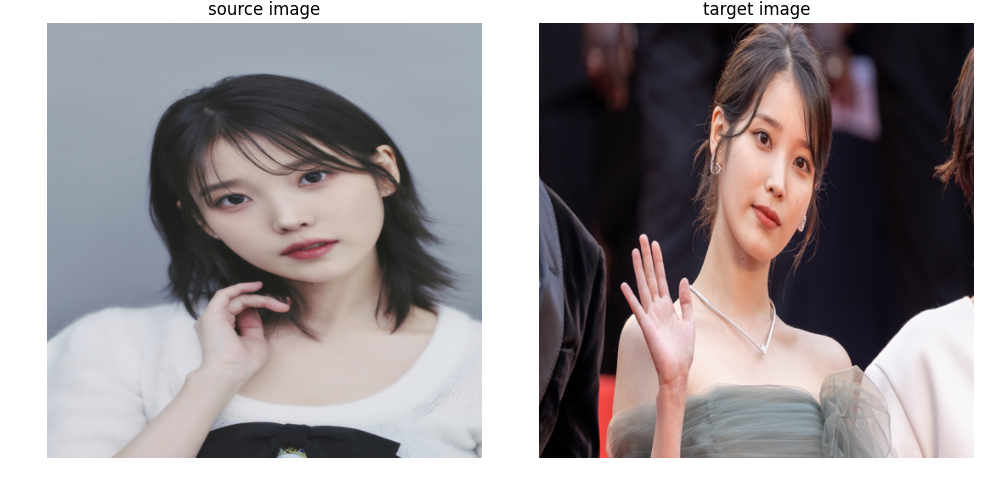

In [20]:
demo.plot_img_pairs(fig_size=5)